# Ising Model - Fred Bunt
## Problem 15.7 a-d

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec

In [ ]:
UP = 1
DOWN = -1


class IsingSim:
    def __init__(self, L, energy):
        self.L = L
        self.N = L * L
        self.target_energy = energy
        self.sys_energy = 0
        self.dem_energy = 0
        self.mcs = 0
        self.sys_energy_acc = 0
        self.dem_energy_acc = 0
        self.magnetization = 0
        self.m_acc = 0
        self.m2_acc = 0
        self.accepted_moves = 0
        self.temperature = 0

        self.lattice = np.full((L, L), UP, dtype=np.int8)

        nx = [1, -1, 0, 0]
        ny = [0, 0, 1, -1]
        # Lookup table of neighbor direction vectors
        self.dirs = np.array(list(zip(nx, ny)))
        self.irand = 0
        self.nrand = 1024 * 10
        self.rand_pts = np.random.randint(self.L, size=(self.nrand, 2))

        self.init()
        
    def reset_acc(self):
        self.sys_energy_acc = 0
        self.dem_energy_acc = 0
        self.m_acc = 0
        self.m2_acc = 0
        self.mcs = 0

    def init(self):
        tries = 0
        energy = -self.N
        mag = self.N
        max_tries = 10 * self.N
        while energy < self.target_energy and tries < max_tries:
            pt = self.get_random_pt()
            de = self.get_delta(pt)
            if de > 0:
                energy += de
                spin = -self.lattice[pt]
                self.lattice[pt] = spin
                mag += 2 * spin
            tries += 1
        self.sys_energy = energy
        self.magnetization = mag

    def step(self):
        for i in range(self.N):
            pt = self.get_random_pt()
            de = self.get_delta(pt)
            if de <= self.dem_energy:
                spin = -self.lattice[pt]
                self.lattice[pt] = spin
                self.accepted_moves += 1
                self.sys_energy += de
                self.dem_energy -= de
                self.magnetization += 2 * spin
            self.sys_energy_acc += self.sys_energy
            self.dem_energy_acc += self.dem_energy
            self.m_acc += self.magnetization
            self.m2_acc += self.magnetization * self.magnetization
        self.mcs += 1
        self.temperature = 4.0 / np.log(
            1 + (4 * self.mcs * self.N / self.dem_energy_acc)
        )

    def get_delta(self, pt):
        # (-1, 0) and (0, -1) allow periodic wrapping from the left and top
        # edges to the right and bottom edges thanks to -1 wrapping to the end
        # in python. (1, 0) and (0, 1) don't.
        nn = pt + self.dirs
        # Enforce periodic condition for (1, 0) and (0, 1)
        nn[nn == self.L] = 0
        # Use indexing tricks to get neighbors quickly and sum them
        de = 2 * self.lattice[pt] * self.lattice[nn.T[0], nn.T[1]].sum()
        return de

    def get_random_pt(self):
        if self.irand >= self.nrand:
            self.irand = 0
            self.rand_pts = np.random.randint(self.L, size=(self.nrand, 2))
        pt = self.rand_pts[self.irand]
        self.irand += 1
        return tuple(pt)
    
    
def run_sim(sim, iters):
    for _ in range(iters):
        sim.step()

In [7]:
class SimAnimation:
    def __init__(
        self,
        sim,
        interval,
        artist_class,
        max_iter=None,
        figsize=None,
        notebook=True,
    ):
        self.notebook = notebook
        self.max_iter = max_iter
        self.sim = sim
        self.im = None
        self.ani = None
        self.fig = plt.figure(figsize=figsize)
        self.interval = interval
        self.paused = False
        self.artist = artist_class(sim, self.fig)

    def init(self):
        return self.artist.init()

    def update(self, step):
        return self.artist.update(step)

    def on_click(self, event):
        """Toggle play/pause with space bar. Handy for non-jupyter runs."""
        if event.key != " ":
            return
        if self.paused:
            self.ani.event_source.start()
            self.paused = False
        else:
            self.ani.event_source.stop()
            self.paused = True

    def run(self):
        self.fig.canvas.mpl_connect("key_press_event", self.on_click)
        self.ani = FuncAnimation(
            self.fig,
            self.update,
            frames=self.max_iter,
            init_func=self.init,
            interval=self.interval,
        )
        if not self.notebook:
            plt.show()
        else:
            return HTML(self.ani.to_html5_video())

## Part (a)

In [8]:
class SimPlotterA:
    def __init__(self, sim, fig):
        self.sim = sim
        self.fig = fig
        self.im = None
        self.steps = []
        self.data = {
            "sys_energy": [],
            "dem_energy": [],
            "mag": [],
            "tmp": [],
        }
        self.min_max = {
            "sys_energy": [self.sim.sys_energy, self.sim.sys_energy],
            "dem_energy": [self.sim.dem_energy, self.sim.dem_energy],
            "mag": [self.sim.magnetization, self.sim.magnetization],
            "tmp": [self.sim.temperature, self.sim.temperature],
        }
        gs = GridSpec(2, 2)
        self.im_ax = self.fig.add_subplot(gs[0, 0])
        self.mag_ax = self.fig.add_subplot(gs[1, 0])
        self.sys_ax = self.fig.add_subplot(gs[0, 1])
        self.tmp_ax = self.fig.add_subplot(gs[1, 1])
        self.im = self.im_ax.imshow(
            np.full_like(self.sim.lattice, UP),
            interpolation="none",
            animated=True,
            cmap="gray",
            vmin=DOWN,
            vmax=UP,
        )
        (self.mag_line,) = self.mag_ax.plot(self.steps, self.data["mag"])
        self.mag_ax.set_title("Magnetization")
        self.mag_ax.set_xlabel("Steps")
        (self.sys_line,) = self.sys_ax.plot(
            self.steps, self.data["dem_energy"]
        )
        self.sys_ax.set_title("System Energy")
        self.sys_ax.set_xlabel("Steps")
        (self.tmp_line,) = self.tmp_ax.plot(self.steps, self.data["tmp"])
        self.tmp_ax.set_title("Temperature")
        self.tmp_ax.set_xlabel("Steps")
        self.axs = (self.mag_ax, self.sys_ax, self.tmp_ax)
        for ax in self.axs:
            ax.grid()
        self.artists = [self.im, self.mag_line, self.sys_line, self.tmp_line]
        plt.tight_layout()

    def _update_data(self, k, v):
        self.data[k].append(v)
        mm = self.min_max[k]
        if v < mm[0]:
            mm[0] = v
        if v > mm[1]:
            mm[1] = v

    def init(self):
        return self.artists

    def update(self, step):
        self.steps.append(step)
        self.sim.step()
        self._update_data("sys_energy", self.sim.sys_energy)
        self._update_data("dem_energy", self.sim.dem_energy)
        self._update_data("mag", self.sim.magnetization)
        self._update_data("tmp", self.sim.temperature)

        self.im.set_data(self.sim.lattice)
        self.mag_line.set_data(self.steps, self.data["mag"])
        self.sys_line.set_data(self.steps, self.data["sys_energy"])
        self.tmp_line.set_data(self.steps, self.data["tmp"])
        self.mag_ax.set_ylim(*self.min_max["mag"])
        # Add buffer so that data isn't obscured by axes lines
        mm = self.min_max["sys_energy"]
        self.sys_ax.set_ylim(mm[0] - 1, mm[1] + 1)
        self.tmp_ax.set_ylim(*self.min_max["tmp"])
        self.mag_ax.set_xlim(-1, step)
        self.sys_ax.set_xlim(-1, step)
        self.tmp_ax.set_xlim(-1, step)
        return self.artists

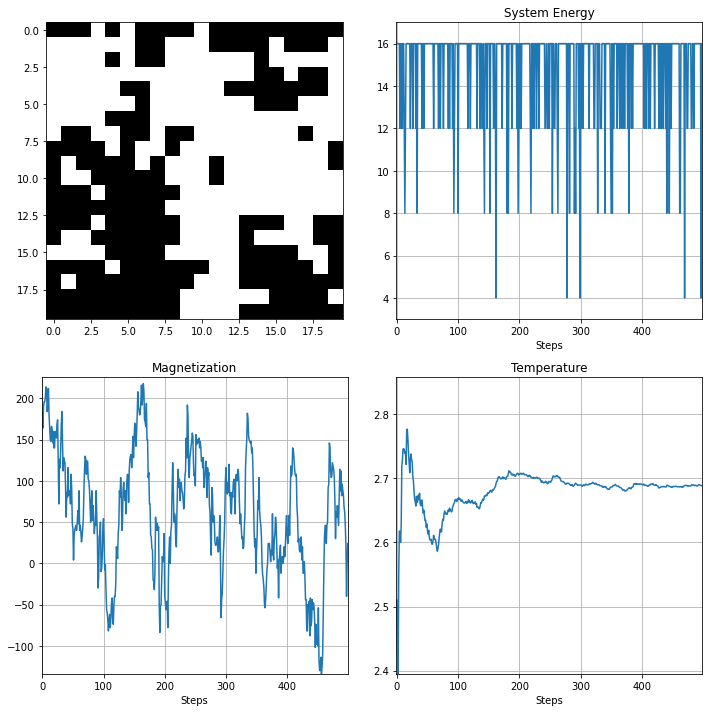

In [9]:
sima = IsingSim(20, 10)
sima.step()
SimAnimation(sima, 100, SimPlotterA, max_iter=500, figsize=(10, 10)).run()

## Part (b)

In [32]:
energies = np.linspace(-300, 300, 20)
ed_avg = []
m2_avg = []
N = 500
L = 20
for e in energies:
    print(f"Running: {e}")
    sim = IsingSim(L, e)
    # Run for short period to reach steady(ish)-state
    run_sim(sim, 150)
    sim.reset_acc()
    # Run in steady state to get means
    run_sim(sim, N)
    ed_avg.append(sim.dem_energy_acc / N)
    m2_avg.append(sim.m2_acc / N)

Running: -300.0
Running: -268.42105263157896
Running: -236.8421052631579
Running: -205.26315789473685
Running: -173.68421052631578
Running: -142.10526315789474
Running: -110.5263157894737
Running: -78.94736842105263
Running: -47.36842105263159
Running: -15.78947368421052
Running: 15.78947368421052
Running: 47.36842105263156
Running: 78.9473684210526
Running: 110.52631578947364
Running: 142.10526315789474
Running: 173.68421052631578
Running: 205.26315789473682
Running: 236.84210526315792
Running: 268.42105263157896
Running: 300.0


For negative energies, the magnetization's magnitude is high but it balances out
for positive energies. The E vs E_d and T plots
turn out as expected though. The last plot shows how kT is approximately equal
to E_d for |J/E_d| << 1. Since J and k are 1 in the simulations, T = E_d, here.

Text(0.5, 1.0, 'T vs E')

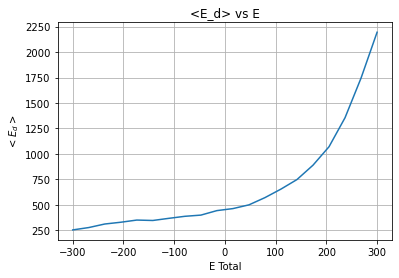

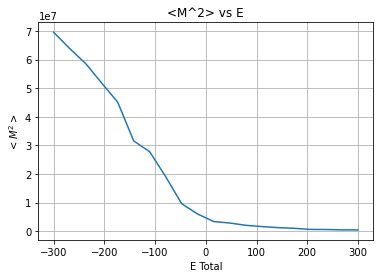

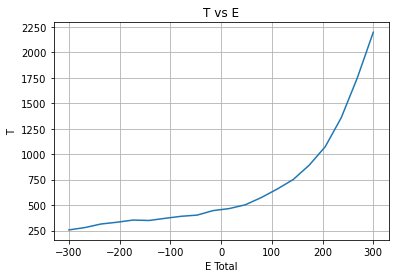

In [33]:
ed_avg = np.array(ed_avg)
temp = 4 / np.log(1 + (4 / ed_avg))

plt.figure()
plt.plot(energies, ed_avg)
plt.grid()
plt.xlabel("E Total")
plt.ylabel("$<E_d>$")
plt.title("<E_d> vs E")

plt.figure()
plt.plot(energies, m2_avg)
plt.grid()
plt.xlabel("E Total")
plt.ylabel("$<M^2>$")
plt.title("<M^2> vs E")

plt.figure()
plt.plot(energies, temp)
plt.grid()
plt.xlabel("E Total")
plt.ylabel("T")
plt.title("T vs E")

## Part (c)
Larger lattices require more time to reach equilibrium. The E vs T
relationship seems unchanged apart from the steeper growth. This may
simply be due to the minimum and maximum bounds I chose.
#### Longer runs

In [34]:
energies = np.linspace(-300, 300, 20)
ed_avg = []
m2_avg = []
N = 800
L = 20
for e in energies:
    print(f"Running: {e}")
    sim = IsingSim(L, e)
    # Run for short period to reach steady(ish)-state
    run_sim(sim, 200)
    sim.reset_acc()
    # Run in steady state to get means
    run_sim(sim, N)
    ed_avg.append(sim.dem_energy_acc / N)
    m2_avg.append(sim.m2_acc / N)

Running: -300.0
Running: -268.42105263157896
Running: -236.8421052631579
Running: -205.26315789473685
Running: -173.68421052631578
Running: -142.10526315789474
Running: -110.5263157894737
Running: -78.94736842105263
Running: -47.36842105263159
Running: -15.78947368421052
Running: 15.78947368421052
Running: 47.36842105263156
Running: 78.9473684210526
Running: 110.52631578947364
Running: 142.10526315789474
Running: 173.68421052631578
Running: 205.26315789473682
Running: 236.84210526315792
Running: 268.42105263157896
Running: 300.0


Text(0.5, 1.0, 'T vs E')

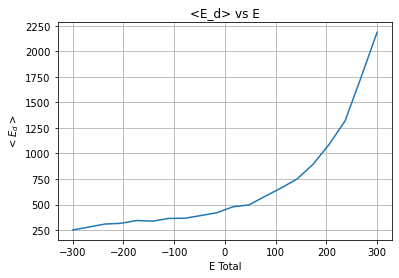

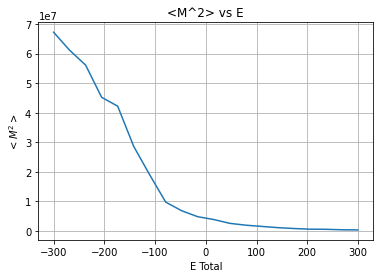

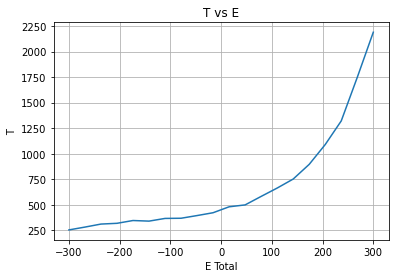

In [35]:
ed_avg = np.array(ed_avg)
temp = 4 / np.log(1 + (4 / ed_avg))

plt.figure()
plt.plot(energies, ed_avg)
plt.grid()
plt.xlabel("E Total")
plt.ylabel("$<E_d>$")
plt.title("<E_d> vs E")

plt.figure()
plt.plot(energies, m2_avg)
plt.grid()
plt.xlabel("E Total")
plt.ylabel("$<M^2>$")
plt.title("<M^2> vs E")

plt.figure()
plt.plot(energies, temp)
plt.grid()
plt.xlabel("E Total")
plt.ylabel("T")
plt.title("T vs E")

#### Larger Lattice

In [45]:
energies = np.linspace(-1500, 1500, 20)
ed_avg = []
m2_avg = []
N = 500
L = 40
for e in energies:
    print(f"Running: {e}")
    sim = IsingSim(L, e)
    # Run for short period to reach steady(ish)-state
    run_sim(sim, 200)
    sim.reset_acc()
    # Run in steady state to get means
    run_sim(sim, N)
    ed_avg.append(sim.dem_energy_acc / N)
    m2_avg.append(sim.m2_acc / N)

Running: -1500.0
Running: -1342.1052631578948
Running: -1184.2105263157896
Running: -1026.3157894736842
Running: -868.421052631579
Running: -710.5263157894738
Running: -552.6315789473684
Running: -394.7368421052631
Running: -236.84210526315792
Running: -78.94736842105272
Running: 78.94736842105249
Running: 236.84210526315792
Running: 394.7368421052631
Running: 552.6315789473683
Running: 710.5263157894738
Running: 868.4210526315787
Running: 1026.3157894736842
Running: 1184.2105263157896
Running: 1342.1052631578946
Running: 1500.0


Text(0.5, 1.0, 'T vs E')

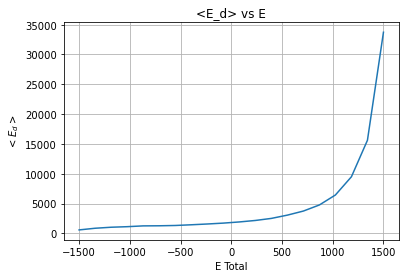

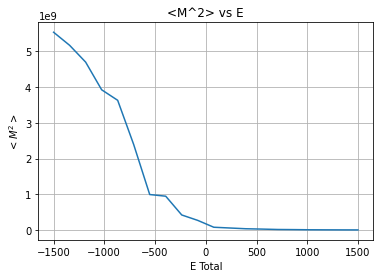

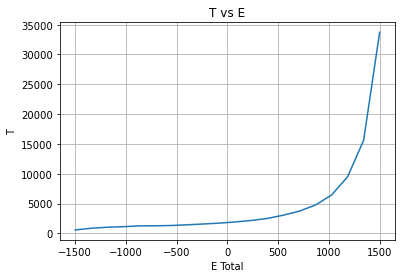

In [46]:
ed_avg = np.array(ed_avg)
temp = 4 / np.log(1 + (4 / ed_avg))

plt.figure()
plt.plot(energies, ed_avg)
plt.grid()
plt.xlabel("E Total")
plt.ylabel("$<E_d>$")
plt.title("<E_d> vs E")

plt.figure()
plt.plot(energies, m2_avg)
plt.grid()
plt.xlabel("E Total")
plt.ylabel("$<M^2>$")
plt.title("<M^2> vs E")

plt.figure()
plt.plot(energies, temp)
plt.grid()
plt.xlabel("E Total")
plt.ylabel("T")
plt.title("T vs E")

## Part (d)

There are definitely domains forming at all energy levels but they are much
larger at lower energies. The disorder grows with the energy level. This
accounts for the magnetization curve's behavior. With low disorder and larger
domains, the lattice becomes magnetic. With high disorder and smaller domains,
no one spin dominates.

Running: 0
Running: 1
Running: 2
Running: 3
Running: 4
Running: 5
Running: 6
Running: 7
Running: 8


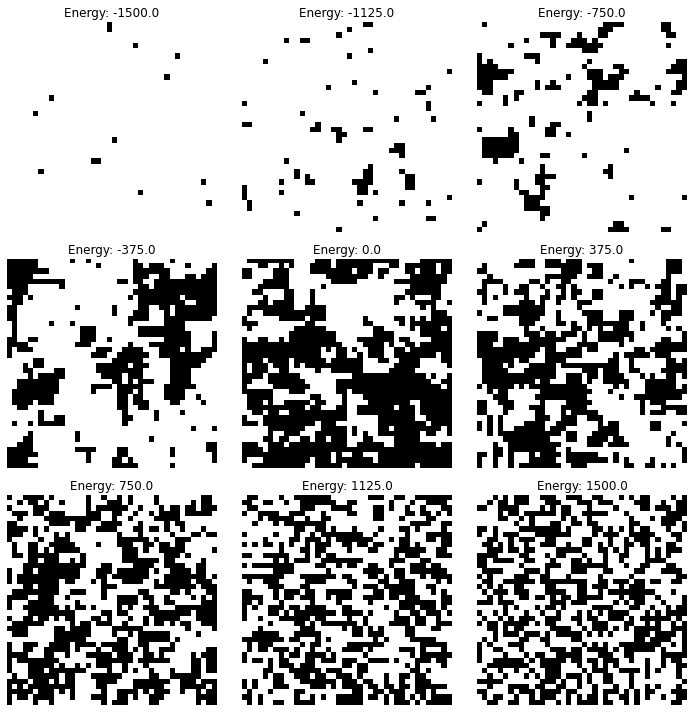

In [47]:
L = 40
N = 600
energies_d = np.linspace(-1500, 1500, 9)
sims = [IsingSim(L, e) for e in energies_d]
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
k = 0
for i in range(3):
    for j in range(3):
        print(f"Running: {k}")
        sim = sims[k]
        run_sim(sim, N)
        axs[i, j].imshow(sim.lattice, cmap="gray")
        axs[i, j].set_title(f"Energy: {energies_d[k]:.1f}")
        axs[i, j].axis("off")
        k += 1
plt.tight_layout()